# Training a Neural Network To Predict Incubator Temperature

In this notebook we give you an example on how to train a neural network to predict the incubator temperature, from previous temperatures as well as control commands.

The network therefore has a similar interface to the incubator fmu created in previous notebooks.

## Dataset

The following is the dataset we will be using:

In [1]:
# Get CSV file from an incubator dataset
import os

# Get the current working directory.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '3-Physics-Modelling', 'Current directory is not 3-Physics-Modelling'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

csv_file_path = os.path.join(parent_dir, 'incubator_dt', 'software', 'incubator', 'datasets', '20230501_calibration_empty_system', '20230501_calibration_empty_system.csv')

assert os.path.exists(csv_file_path), '20230501_calibration_empty_system.csv not found in the incubator repository.'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(csv_file_path)
data['heater_on_int'] = data['heater_on'].astype(int)
data.head()

,time,t1,time_t1,t2,time_t2,t3,time_t3,average_temperature,heater_on,fan_on,execution_interval,elapsed,heater_on_int
0,1682912554273107499,23.062,1682912554192856639,24.312,1682912554232822932,22.125,1682912554272705263,23.6870,False,False,3.0,1.025402,0
1,1682912557313698460,23.062,1682912557272792494,24.375,1682912557232848441,22.125,1682912557313344724,23.7185,False,False,3.0,1.064928,0
2,1682912560282455551,23.062,1682912560232232220,24.375,1682912560192178595,22.062,1682912560282224276,23.7185,False,False,3.0,1.031638,0
3,1682912563313803672,23.125,1682912563273056592,24.375,1682912563232827969,22.062,1682912563313317234,23.7500,False,False,3.0,1.061013,0
4,1682912566283347240,23.125,1682912566243313892,24.375,1682912566192896637,22.062,1682912566282895616,23.7500,False,False,3.0,1.028555,0


We will now create subplots to visualize the temperature and the control signal (heater) over time. This helps us understand how the data behaves and how the heater's state affects the temperature.

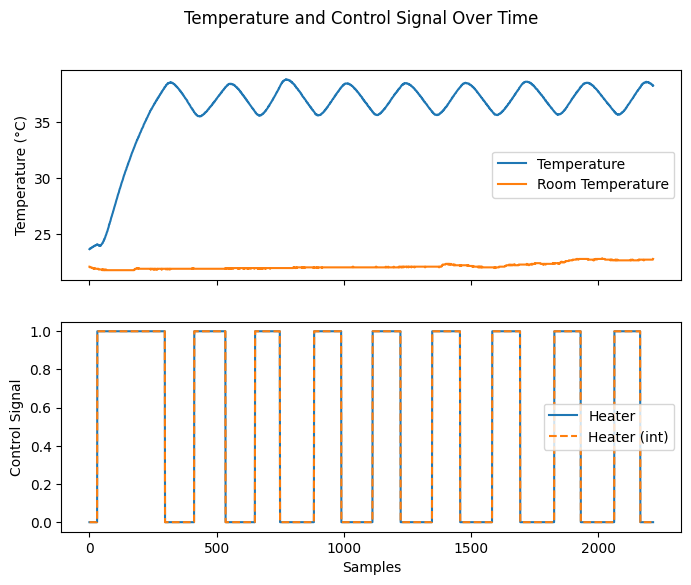

In [3]:
# Create subplots with shared X-axis for temperature and control signal.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot temperature data on the first subplot
ax1.plot(data.index, data.average_temperature, label='Temperature')
ax1.plot(data.index, data.t3, label='Room Temperature')
ax1.set_ylabel('Temperature (°C)')
ax1.legend()

# Plot control signal data on the second subplot (heater on/off)
ax2.plot(data.index, data.heater_on, label='Heater')
ax2.plot(data.index, data.heater_on_int, label='Heater (int)', linestyle='--')  # Verification
ax2.set_xlabel('Samples')
ax2.set_ylabel('Control Signal')
ax2.legend()

# Add a title to the shared X-axis
fig.suptitle('Temperature and Control Signal Over Time')

# Show the plots
plt.show()

## Neural Network

### Problem Overview
The goal of the neural network is to predict the **next temperature** of a system based on historical data. In this case, the system measures:
- **Average temperature (`average_temperature`)**: This is the main feature we are trying to predict for the next time step.
- **Room temperature (`t3`)**: This is the ambient room temperature, which may influence the system’s temperature.
- **Heater state (`heater_on`)**: This binary value indicates whether the heater is on (1) or off (0), affecting how the temperature evolves.

We use these variables at a given time (let's call it time `t`) to predict the temperature at the next time step (`t+1`).

#### Inputs of the Neural Network
The neural network takes in **three inputs** at each time step `t` to make the prediction for time `t+1`:

1. **`previous_T` (previous average temperature)**:  
   This is the temperature of the system at time `t`. It captures the state of the system at the current time step. The neural network uses this to infer how much the temperature is likely to change.

2. **`previous_RoomT` (previous room temperature)**:  
   This is the room (ambient) temperature at time `t`. Since external conditions affect the temperature inside the system, knowing the room temperature helps the neural network understand the external environment's influence on the system.

3. **`previous_H` (previous heater state)**:  
   This is a binary feature indicating whether the heater was ON or OFF at time `t`. It has a significant impact on temperature dynamics since the heater increases the system’s temperature when ON. The neural network will learn how the heater state influences temperature changes.

These three input features form a **3-dimensional vector** representing the system's state at time `t`.

#### Outputs of the Neural Network
The neural network produces **one output**:

- **`next_T` (next average temperature)**:  
  This is the predicted average temperature at time `t+1`. The goal of the neural network is to learn the relationship between the current system state (given by the three input features) and the future temperature, so it can make accurate predictions.

Thus, the neural network's job is to map the input vector `[previous_T, previous_RoomT, previous_H]` to a scalar output `next_T`, which represents the system's temperature at the next time step.

#### Why These Inputs and Outputs?
- **Historical temperature**: The temperature of a system tends to evolve gradually, meaning that the current temperature is likely a good indicator of what the temperature will be in the near future. This is why `previous_T` is used as an input.
  
- **Room temperature**: If the room temperature is significantly different from the system’s temperature, it could cause the system’s temperature to change more rapidly (e.g., cooling down when the room is cold). Therefore, including `previous_RoomT` helps the model learn how external conditions affect the system.

- **Heater state**: The heater directly affects the temperature. When it’s on, the system’s temperature increases. By including `previous_H`, the model learns how much the heater impacts the temperature changes.

#### Neural Network Architecture
In this case, the architecture is a simple **linear regression model**:

- **Input layer**: Takes the three features `[previous_T, previous_RoomT, previous_H]`.
- **Output layer**: Produces a single output, which is the predicted `next_T` (the temperature at the next time step).

### Preparing the Dataset for Training

To make predictions, we need to use past data to predict future data. Here we shift the data to create input-output pairs: 
- The input (`previous_T`) is the temperature at time `t`.
- The output (`next_T`) is the temperature at time `t+1`.

In [4]:
# Prepare training data with shifted time series
nn_data = pd.DataFrame()

# Use previous temperature, room temperature, and heater state as inputs
nn_data['previous_T'] = data.loc[0:data.index[-2], 'average_temperature']
nn_data['previous_RoomT'] = data.loc[0:data.index[-2], 't3']
nn_data['previous_H'] = data.loc[0:data.index[-2], 'heater_on_int']

# The target is the next temperature
nn_data['next_T'] = data.loc[1:data.index[-1], 'average_temperature'].to_numpy()

# Verify that the data is aligned correctly
for i in range(0, nn_data.index[-2]):
    assert nn_data.loc[i+1,'previous_T'] == nn_data.loc[i,'next_T']

nn_data.head()

,previous_T,previous_RoomT,previous_H,next_T
0,23.6870,22.125,0,23.7185
1,23.7185,22.125,0,23.7185
2,23.7185,22.062,0,23.7500
3,23.7500,22.062,0,23.7500
4,23.7500,22.062,0,23.7500


#### Splitting Data into Training and Testing Sets

We split the data into training and testing sets to evaluate the model's performance. Typically, around 70% of the data is used for training, and 30% for testing.

In [5]:
rows_to_drop = int(0.3 * len(nn_data))
training_data = nn_data.iloc[:-rows_to_drop]
test_data = nn_data.iloc[-rows_to_drop:]

# Verify that the split was done correctly
assert len(training_data) + len(test_data) == len(nn_data)

#### Convert Data to Tensors for PyTorch

PyTorch models require input data in the form of tensors. We convert the input features (`previous_T`, `previous_RoomT`, `previous_H`) and the target (`next_T`) into tensors.

In [6]:
import torch

# Function to convert pandas DataFrame into PyTorch tensors
def convert_to_torch_inputs_outputs(df):
    X = torch.tensor(df[['previous_T', 'previous_RoomT', 'previous_H']].values, dtype=torch.float32)
    Y = torch.tensor(df[['next_T']].values, dtype=torch.float32)
    return X, Y

# Convert training data to tensors
X_train, Y_train = convert_to_torch_inputs_outputs(training_data)

In [7]:
X_train

tensor([[23.6870, 22.1250,  0.0000],
        [23.7185, 22.1250,  0.0000],
        [23.7185, 22.0620,  0.0000],
        ...,
        [36.9685, 22.0620,  0.0000],
        [36.9060, 22.0620,  0.0000],
        [36.9060, 22.0620,  0.0000]])

In [8]:
Y_train

tensor([[23.7185],
        [23.7185],
        [23.7500],
        ...,
        [36.9060],
        [36.9060],
        [36.8750]])

### Creating and Training the Neural Network

In [9]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network model (a simple linear regression model)
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(3, 1)  # 3 input features and 1 output

    def forward(self, x):
        return self.linear(x)

# Initialize the model and define the loss function (Mean Squared Error)
model = LinearRegression()
model

LinearRegression(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

We use the Adam optimizer and train the model for 5000 epochs, updating the model’s parameters to minimize the loss (Mean Squared Error).

In [10]:
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 5000  # Number of epochs to train

# Define the loss function (Mean Squared Error)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero out gradients
    outputs = model(X_train)  # Forward pass
    loss = loss_fn(outputs, Y_train)  # Compute the loss
    loss.backward()  # Backpropagation
    
    optimizer.step()  # Update model parameters

    # Print loss periodically for monitoring
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [500/5000], Loss: 0.0014
Epoch [1000/5000], Loss: 0.0012
Epoch [1500/5000], Loss: 0.0011
Epoch [2000/5000], Loss: 0.0010
Epoch [2500/5000], Loss: 0.0010
Epoch [3000/5000], Loss: 0.0010
Epoch [3500/5000], Loss: 0.0009
Epoch [4000/5000], Loss: 0.0009
Epoch [4500/5000], Loss: 0.0009
Epoch [5000/5000], Loss: 0.0009


### Making Predictions and Visualizing Results

We use the trained model to predict the next temperature for the entire dataset. Then we compare the predicted values with the actual ones.

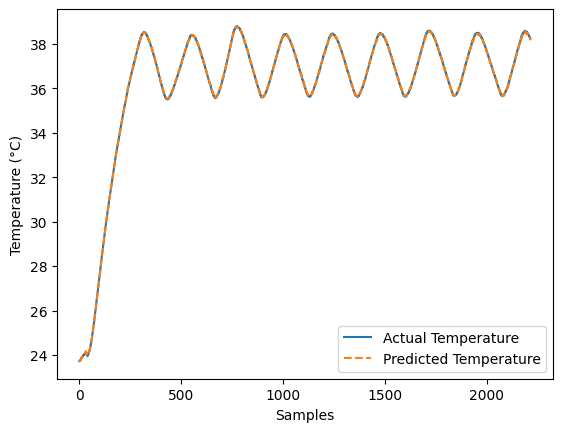

In [11]:
# Convert the full dataset to tensors and predict temperatures
X_full, _ = convert_to_torch_inputs_outputs(nn_data)
nn_data['next_T_predicted'] = model(X_full).detach().numpy()

# Plot actual vs. predicted temperatures
plt.plot(nn_data.index, nn_data.next_T, label='Actual Temperature')
plt.plot(nn_data.index, nn_data.next_T_predicted, label='Predicted Temperature', linestyle='--')
plt.ylabel('Temperature (°C)')
plt.xlabel('Samples')
plt.legend()

# Show the plot
plt.show()

## Discussion

### So... what have we done? 

We have trained a neural network (NN) that is capable of predicting the next temperature from a given previous temperature examples as well as control actuation.
This approach is very easy but has severe drawbacks when compared to building an ODE model as in the previous notebooks:
1. The NN has no notion of parameters so it is intimately tied to the physical incubator used to generate the dataset. Change the incubator box for instance, and a new data set would have to be generated for that new incubator to retrain the NN. To be fair, for the ODE model we would also have to find the new values for the parameters that correspond to the new box (we will talk about model calibration later in the course).
2. The NN does not predict the heater temperature like the ODE does. It's simply non existant since it's not on the dataset.
3. The NN assumes a fixed timestep corresponding to the timestep of the dataset samples.
4. The NN should not be used in a closed loop simulation when we where we couple the controller with the NN. This is because in such a scenario the predictions of the network actually have to make it back to the inputs of the network as previous temperature readings. This means that any errors made in the predictions tend to accumulate over time, leading to excessively high prediction errors. This does not happen in the ODE model because the numerical solver uses clever tricks to prevent excessive accumulation of error over time. An example is given below to illustrate how bad the predictions become over time.

In [12]:
# The following code uses the model in a closed loop to conduct a simulation and compares the result of simulatio with the real data.

# Create a tensor object that will be used to store the inputs of the model
input = torch.randn(1, 3)

simulated_T = nn_data.loc[0].previous_T
simulated_Ts = []  # Keep predictions in a simple list

for step in nn_data.index:

  # Prepare inputs for the model
  input[0,0] = simulated_T  # corresponds to previous_T, but since we are making simulation it will be a previous model output
  input[0,1] = nn_data.loc[step]['previous_RoomT']
  input[0,2] = nn_data.loc[step]['previous_H']

  output = model(input).detach().numpy()

  simulated_T = float(output[0,0])
  simulated_Ts.append(simulated_T)

# Add the simulation to the nice table
nn_data["T_simulation"] = simulated_Ts
nn_data

,previous_T,previous_RoomT,previous_H,next_T,next_T_predicted,T_simulation
0,23.6870,22.125,0,23.7185,23.686783,23.686783
1,23.7185,22.125,0,23.7185,23.718237,23.686565
2,23.7185,22.062,0,23.7500,23.721050,23.689161
3,23.7500,22.062,0,23.7500,23.752504,23.691753
4,23.7500,22.062,0,23.7500,23.752504,23.694342
...,...,...,...,...,...,...
2210,38.3435,22.750,0,38.3435,38.293934,28.309740
2211,38.3435,22.750,0,38.3125,38.293934,28.274853
2212,38.3125,22.750,0,38.2495,38.262981,28.240017
2213,38.2495,22.750,0,38.2810,38.200073,28.205233


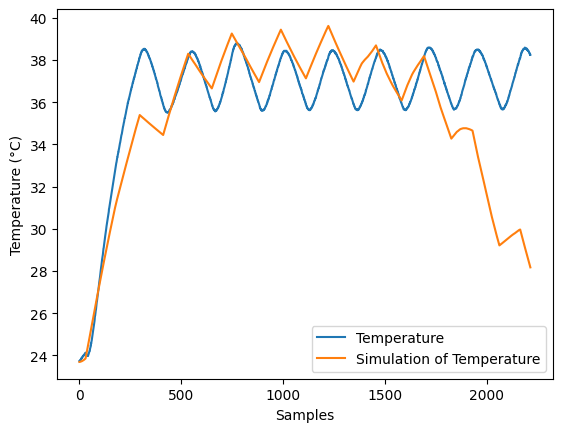

In [13]:
# Plot previous simulation
plt.plot(nn_data.index, nn_data.next_T, label='Temperature')
plt.plot(nn_data.index, nn_data.T_simulation, label='Simulation of Temperature')
plt.ylabel('Temperature (°C)')
plt.xlabel('Samples')
plt.legend()

# Show the plots
plt.show()

As you can see the results are less than ideal! Spend some time analyzing the differences between the above "close loop simulation" use case of the neural network with the previous "one step prediction" use case, where the neural network performed a lot better.

### Then... what can the NN be used for?

A neural network trained as in the above scenario is ideal for building a digital twin monitoring service. 
Recall that earlier you have deployed a MovingAverageTemperatureService. 
In the next notebook, we will do the same, except instead of a moving average, we will use the NN to predict the next temperature, and the PTReconfigurationService will use the differences between the prediction and actual to reconfigure the controller when the lid is open.

Before we move on, let us store our trained model and create a few python scripts that will be used in the next notebook.

In [14]:
# Basic consistency check to see if above is still consistent with previous notebooks.
current_dir = os.getcwd()
assert os.path.basename(current_dir) == '3-Physics-Modelling', 'Current directory is not 3-Physics-Modelling'
parent_dir = os.path.dirname(current_dir)
assert os.path.exists(os.path.join(parent_dir, '1-Incubator-Service', '3-PTReconfigurationService.ipynb')), '3-PTReconfigurationService.ipynb folder not found in the repository'

In [15]:
# Store trained model parameters

# Define a path to save the model
model_save_path = "temperature_prediction_model.pth"

# Save the trained model's state dictionary (the model's learned parameters)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to temperature_prediction_model.pth


In [16]:
%%writefile temperature_prediction_model.py
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model (a simple linear regression model). Note that this much match the model architecture used in training
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(3, 1)  # 3 input features and 1 output

    def forward(self, x):
        return self.linear(x)

class IncubatorPredictionNN:
    def __init__(self, model_path='temperature_prediction_model.pth'):
        # Instantiate the model
        self.model = LinearRegression()

        # Load the saved state dictionary into the model
        self.model.load_state_dict(torch.load(model_path))

        # Set the model to evaluation mode (important for inference)
        self.model.eval()

        self.Tb = 0.0

    def predict_Tb(self, Tb, Tr, H_h):
        # Prepare the inputs to the NN model
        nn_input = torch.tensor([[Tb, Tr, H_h]], dtype=torch.float32)

        # Make the prediction with the neural network
        with torch.no_grad():  # No need to compute gradients during inference
            self.Tb = self.model(nn_input).item()
    
    def get_Tb(self):
        return self.Tb

if __name__ == "__main__":
    # Initialize the incubator prediction model
    # This will load the neural network model from 'temperature_prediction_model.pth'
    model_path = 'temperature_prediction_model.pth'
    incubator_nn = IncubatorPredictionNN(model_path)

    # Provide a set of inputs: 
    # Tb: the current box temperature,
    # Tr: the room temperature,
    # H_h: the heater state (1 for ON, 0 for OFF)
    current_Tb = 25.0  # Current box temperature (in °C)
    room_Temp = 22.0   # Room temperature (in °C)
    heater_state = 1   # Heater state (1: ON, 0: OFF)

    # Predict the next box temperature based on the input data
    incubator_nn.predict_Tb(current_Tb, room_Temp, heater_state)

    # Retrieve and print the predicted temperature
    predicted_Tb = incubator_nn.get_Tb()
    print(f"Predicted next box temperature: {predicted_Tb:.2f} °C")


Overwriting temperature_prediction_model.py


In [17]:
import sys
import subprocess

# Run the script and capture the output
result = subprocess.run(
    [sys.executable, 'temperature_prediction_model.py'], 
    stdout=subprocess.PIPE, 
    stderr=subprocess.PIPE,  # Capture standard error
    text=True,               # Ensures the output is returned as a string, not bytes
    encoding='utf-8',        # Specify the encoding (change if necessary)
    check=True  # Raise an error if the subprocess fails
    )

# Print the output from the script
print(result.stdout)

# Print any errors if there are any
if result.stderr:
    print("Errors: ", result.stderr)

Predicted next box temperature: 25.05 °C

